In [1]:
import numpy as np
import matplotlib.pyplot as plt 
from numba import njit

plt.rc('font', size=15)          # controls default text sizes
plt.rc('axes', titlesize=15)     # fontsize of the axes title
plt.rc('axes', labelsize=15)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12)    # fontsize of the tick labels
plt.rc('legend', fontsize=10)    # legend fontsize
plt.rc('figure', titlesize=20)  # fontsize of the figure title

In [2]:
##### function creating opinion distribution #####
def opinion_dist(N, dist_type, dist_params):
    
    if dist_type == 'normal':
        exp_value = dist_params[0]
        std_deviation = dist_params[1]
        opinion = np.random.normal(exp_value, std_deviation, N) 
        return opinion
    elif dist_type == 'uniform':
        lower_border = dist_params[0]
        upper_border = dist_params[1]
        opinion = np.random.uniform(lower_border, upper_border, N) 
        return opinion
    elif dist_type == 'beta':
        alpha = dist_params[0]
        beta = dist_params[1]
        opinion = (np.random.beta(alpha, beta, N)-0.5)*2 
        return opinion
    else:
        print('unknown dist_type "%s"' %dist_type)
        return

##### opinion rule weight function #####
@njit
def f(opinion_a, opinion_b, epsilon, a):
    
    dist = abs(opinion_a - opinion_b)
    
    if dist == 0:
        weight = 0
    
    elif dist <= epsilon:
        weight = (1-1/epsilon*dist)**a
        if weight < 10**(-5): ##### deactivate for allowing smaller weights
            weight = 10**(-5)
    
    elif dist > epsilon:
        weight = -(1/epsilon*dist-1)**a
        if weight > -10**(-5): ##### deactivate for allowing smaller weights
            weight = -10**(-5)
            
    return weight
    
#### create striving for uniqueness factors #####
@njit
def uniqueness(opinion_dist, s):
    
    Xi = np.zeros(len(opinion_dist))
    
    for i in range(len(opinion_dist)):
        sum_exp = 0
        
        for j in range(len(opinion_dist)):
            sum_exp += np.exp(-abs(opinion_dist[i] - opinion_dist[j]))
            
        Xi[i] = np.random.normal(0, s/len(opinion_dist)*sum_exp)
    
    return Xi
    
##### opinion truncating function #####
@njit    
def trunc_opinion(opinion):

    if opinion < 0:
        new_opinion = 0
    elif opinion > 1:
        new_opinion = 1
    else:
        new_opinion = opinion
    
    return new_opinion

##### opinion dynamics ##### 
@njit
def opinion_dynamics(simulation_time, opinion_dist, epsilon, a, s, freq_step, N_timeline):
    
    opinion_timeline = np.zeros((N_timeline, int(simulation_time/freq_step)))
    values = np.zeros(simulation_time)
    
    for i in range(simulation_time):
        x = np.random.randint(0, len(opinion_dist))
        opinion = opinion_dist[x]
        sum_diffs = 0
        sum_weights = 0
        
        for j in range(len(opinion_dist)):
            sum_diffs += f(opinion, opinion_dist[j], epsilon, a) * (opinion_dist[j]-opinion)
            sum_weights += f(opinion, opinion_dist[j], epsilon, a)
        
        if sum_weights == 0:
            ratio = 0
        else:
            ratio = sum_diffs/sum_weights
        
        ##### activate for limiting the ratio in the opinion update rule #####
        
        #if ratio > 0.075:
        #    ratio = 0.075
        #elif ratio < -0.075:
        #    ratio = -0.075
        
        values[i] = ratio
        
        if s != 0:
            Xi = uniqueness(opinion_dist, s)
        else: 
            Xi = np.zeros(len(opinion_dist))
            
        opinion_dist[x] += ratio + Xi[x] 
        opinion = opinion_dist[x]
        opinion_dist[x] = trunc_opinion(opinion)
        
        if i%freq_step == 0:
            
            for k in range(N_timeline):
                opinion_timeline[k, int(i/freq_step)] = opinion_dist[k]
                
        if i%int(simulation_time*0.1) == 0:
            print(i/simulation_time)
        
    return opinion_dist, opinion_timeline, values

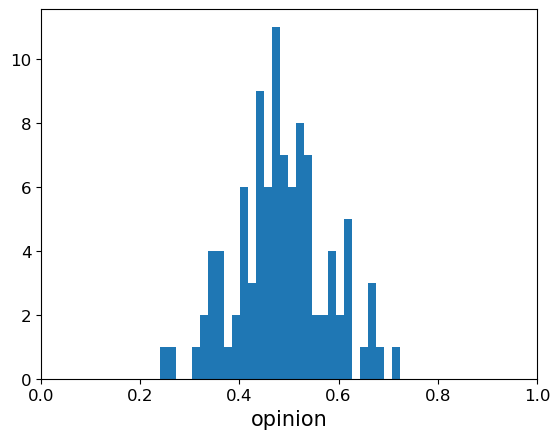

Standard deviation: 0.09309586562419135


In [3]:
##### create and plot initial opinion distribution #####

np.random.seed(45)
N = 100

opinions = opinion_dist(N, 'normal', [0.5, 0.1])

##### ensure every opinion is in the initial range #####
for i in range(N):
    while opinions[i] > 1 or opinions[i] < 0:
        opinions[i] = np.random.normal(0.5, 3)

##### create bi-polarized state #####
#opinions = np.zeros(N)
#for i in range(50):
#    opinions[i] = 0
#    opinions[i+50] = 1

plt.figure()
plt.hist(opinions, bins=30)
plt.xlabel('opinion')
plt.xlim([0,1])
plt.show()

print(f"Standard deviation: {np.std(opinions)}")

In [4]:
##### set simulation parameters #####

simulation_time = 2*10**6
epsilon = 0.5
a = 100
s = 0
border = 1
freq_step = 100 # frequency of saving all opinions to create the timeline

##### run simulation, save new opinions, timeline and weight function values #####
opinions, timeline, values = opinion_dynamics(simulation_time, opinions, epsilon, a, s, freq_step, N)

0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9


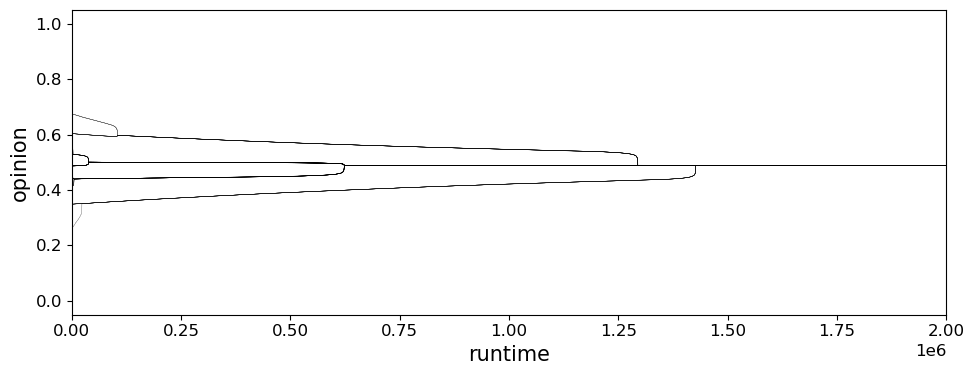

In [5]:
##### plotting the opinion timeline #####

x = np.arange(0, simulation_time, freq_step)
t = np.arange(0, int(simulation_time/freq_step), 1)

plt.figure(figsize=(10,4))
for i in range(0, 100):
    plt.plot(x, timeline[i, t], alpha=0.5, linewidth=0.2, color='black')
plt.xlim([0, simulation_time])
plt.ylim([-0.05,1.05])
plt.xlabel('runtime')
plt.ylabel('opinion')
plt.tight_layout()
#plt.savefig('.png', dpi=200)
plt.show()